In [7]:
import os
import numpy as np
import pandas as pd
import nltk
import common_evaluation
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier, LGBMRegressor

# Download NLTK resources (only needs to be done once)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/i538819/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/i538819/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Preprocessing + Embeddings

In [8]:
def simple_preprocess(text):
    if not isinstance(text, str):
        text = ""
    return word_tokenize(text.lower())

In [9]:
def average_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

## Feature Extractors

In [10]:
def extract_title_features(row, model):
    tokens1 = simple_preprocess(row['title1'])
    tokens2 = simple_preprocess(row['title2'])

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_text_features(row, model):
    tokens1 = simple_preprocess(row['text1'])
    tokens2 = simple_preprocess(row['text2'])

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_combined_features(row, model):
    # --- Title vector ---
    tokens_title1 = simple_preprocess(row['title1'])
    tokens_title2 = simple_preprocess(row['title2'])
    vec_title1 = average_embedding(tokens_title1, model)
    vec_title2 = average_embedding(tokens_title2, model)
    sim_title = cosine_similarity([vec_title1], [vec_title2])[0][0]
    diff_title = np.abs(vec_title1 - vec_title2)
    prod_title = vec_title1 * vec_title2

    # --- Text vector ---
    tokens_text1 = simple_preprocess(row['text1'])
    tokens_text2 = simple_preprocess(row['text2'])
    vec_text1 = average_embedding(tokens_text1, model)
    vec_text2 = average_embedding(tokens_text2, model)
    sim_text = cosine_similarity([vec_text1], [vec_text2])[0][0]
    diff_text = np.abs(vec_text1 - vec_text2)
    prod_text = vec_text1 * vec_text2

    return ([sim_title] + diff_title.tolist() + prod_title.tolist() +
        [sim_text] + diff_text.tolist() + prod_text.tolist() )

def extract_all_features(row, model):
    structured_cols = ['geography', 'entities', 'time', 'narrative', 'style', 'tone']
    # --- Title vector ---
    tokens_title1 = simple_preprocess(row['title1'])
    tokens_title2 = simple_preprocess(row['title2'])
    vec_title1 = average_embedding(tokens_title1, model)
    vec_title2 = average_embedding(tokens_title2, model)
    sim_title = cosine_similarity([vec_title1], [vec_title2])[0][0]
    diff_title = np.abs(vec_title1 - vec_title2)
    prod_title = vec_title1 * vec_title2

    # --- Text vector ---
    tokens_text1 = simple_preprocess(row['text1'])
    tokens_text2 = simple_preprocess(row['text2'])
    vec_text1 = average_embedding(tokens_text1, model)
    vec_text2 = average_embedding(tokens_text2, model)
    sim_text = cosine_similarity([vec_text1], [vec_text2])[0][0]
    diff_text = np.abs(vec_text1 - vec_text2)
    prod_text = vec_text1 * vec_text2

    # --- Structured features ---
    structured = [row[col] for col in structured_cols]

    # --- Final feature vector ---
    return (
        [sim_title] + diff_title.tolist() + prod_title.tolist() +
        [sim_text] + diff_text.tolist() + prod_text.tolist() +
        structured
    )


## Classification Train/Evaluate Function

In [11]:
def run_classification(train_df, test_df, feature_func, model, description, save_json_file_name=None):
    print(f"\n=== Training classification model: {description} ===")

    # Extract training features and labels
    X_train = [feature_func(row, model) if model else feature_func(row) for _, row in train_df.iterrows()]
    y_train = train_df["overall_classification"].values

    # Extract test features and labels
    X_test = [feature_func(row, model) if model else feature_func(row) for _, row in test_df.iterrows()]
    y_test = test_df["overall_classification"].values

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # Train classifier
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbm', LGBMClassifier(n_estimators=100, random_state=42))
    ])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    results = common_evaluation.evaluate_classification(
        y_true=y_test,
        y_pred=y_pred,
        description=description,
        save_json_file_name=save_json_file_name
    )

    return results

## Classification with Word2Vec

Loading CSV...
Loading Word2Vec model ...

=== Training classification model: Title Only - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Title Only - Word2Vec
Accuracy: 0.514
Precision (weighted): 0.505
Recall (weighted): 0.514
F1 Score (weighted): 0.489

Classification Report:
              precision    recall  f1-score   support

           1      0.674     0.483     0.563        60
           2      0.296     0.222     0.254        36
           3      0.350     0.241     0.286        29

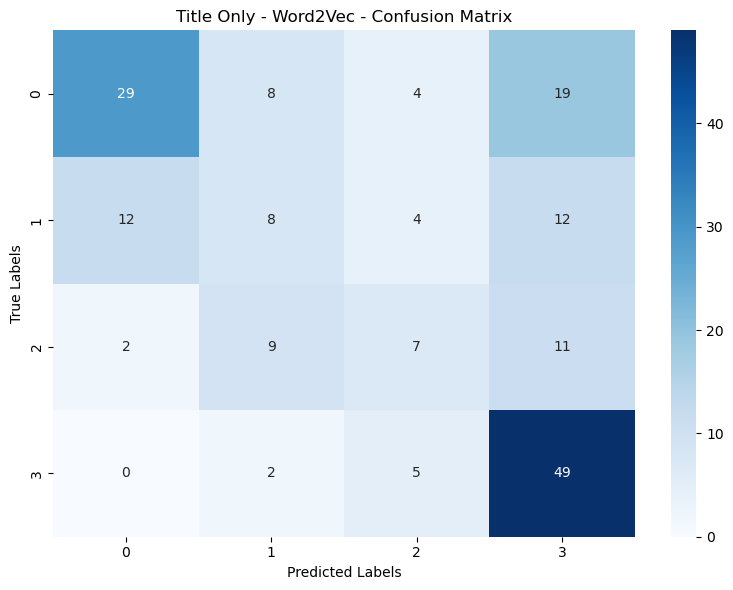


=== Training classification model: Text Only - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Text Only - Word2Vec
Accuracy: 0.552
Precision (weighted): 0.552
Recall (weighted): 0.552
F1 Score (weighted): 0.541

Classification Report:
              precision    recall  f1-score   support

           1      0.651     0.467     0.544        60
           2      0.429     0.417     0.423        36
           3      0.385     0.345     0.364        29
           4      0.610     0.839     0.707

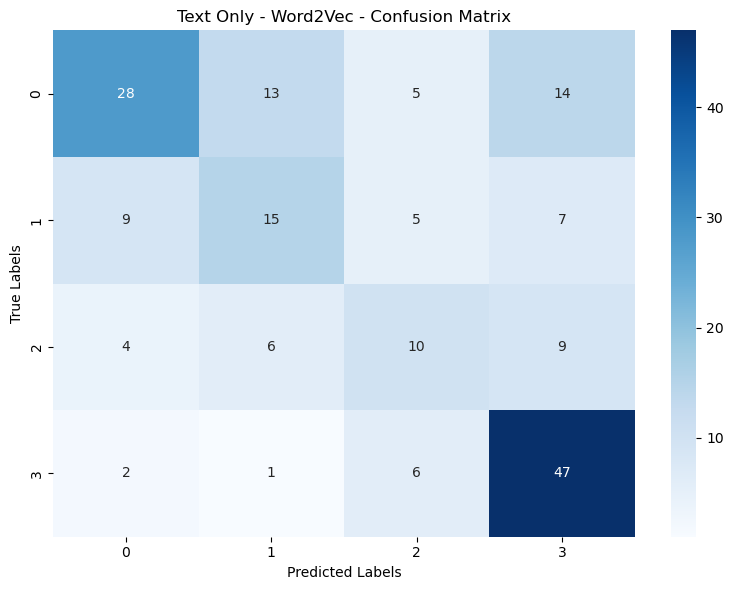


=== Training classification model: Title + Text - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1202
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Title + Text - Word2Vec
Accuracy: 0.591
Precision (weighted): 0.589
Recall (weighted): 0.591
F1 Score (weighted): 0.584

Classification Report:
              precision    recall  f1-score   support

           1      0.755     0.617     0.679        60
           2      0.355     0.306     0.328        36
           3      0.323     0.345     0.333        29
           4      0.700     0.875   

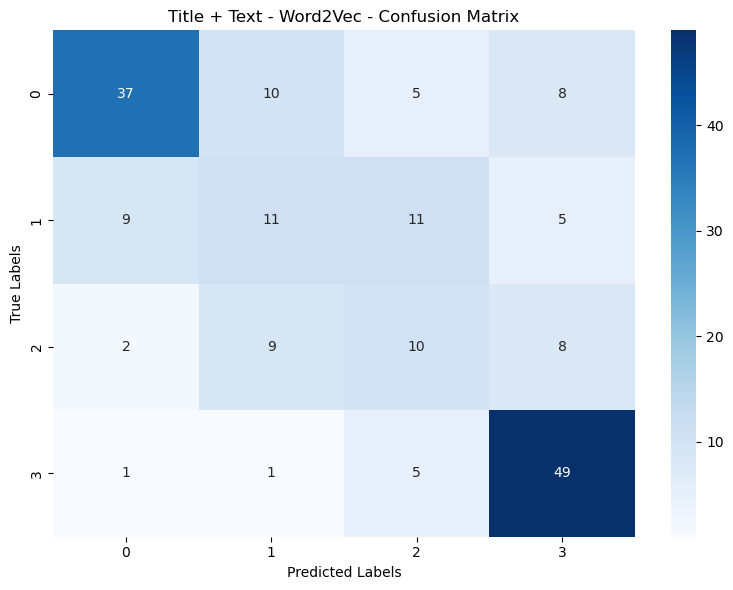


=== Training classification model: All Features - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306629
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1208
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

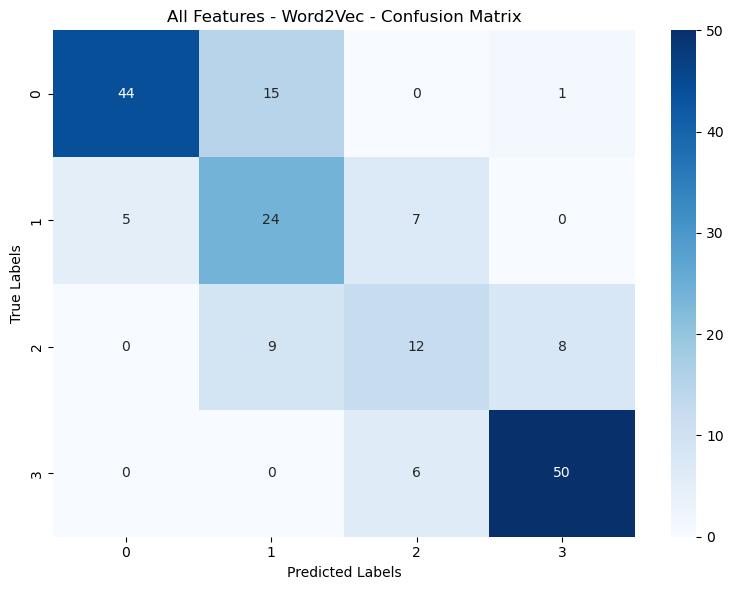

In [12]:
# Load CSV with all pairs
print("Loading CSV...")
train_df = pd.read_csv("data/full_dataset.csv")
test_df = pd.read_csv("test_data/test_dataset.csv")

# Filter for English-only pairs
train_df = train_df[(train_df['lang1'] == 'en') & (train_df['lang2'] == 'en')].reset_index(drop=True)
test_df = test_df[(test_df['lang1'] == 'en') & (test_df['lang2'] == 'en')].reset_index(drop=True)

# Load pre-trained Word2Vec model (Google News vectors)
print("Loading Word2Vec model ...")
model = KeyedVectors.load_word2vec_format("pretrained_models/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

results = []

results.append(run_classification(train_df, test_df, extract_title_features, model, "Title Only - Word2Vec"))
results.append(run_classification(train_df, test_df, extract_text_features, model, "Text Only - Word2Vec"))
results.append(run_classification(train_df, test_df, extract_combined_features, model, "Title + Text - Word2Vec"))
results.append(run_classification(train_df, test_df, extract_all_features, model, "All Features - Word2Vec"))


## Classification with FastText

Loading FastText model...

=== Training classification model: Title Only - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Title Only - FastText
Accuracy: 0.436
Precision (weighted): 0.481
Recall (weighted): 0.436
F1 Score (weighted): 0.390

Classification Report:
              precision    recall  f1-score   support

           1      0.579     0.183     0.278        60
           2      0.550     0.306     0.393        36
           3      0.318     0.241     0.275        29
           4   

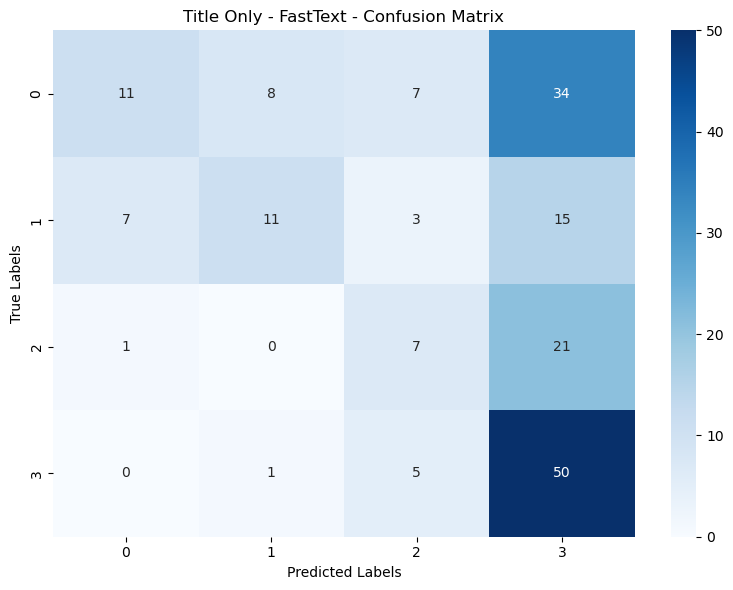


=== Training classification model: Text Only - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Text Only - FastText
Accuracy: 0.497
Precision (weighted): 0.503
Recall (weighted): 0.497
F1 Score (weighted): 0.473

Classification Report:
              precision    recall  f1-score   support

           1      0.613     0.317     0.418        60
           2      0.353     0.333     0.343        36
           3      0.370     0.345     0.357        29
           4      0.551     0.875     0.676

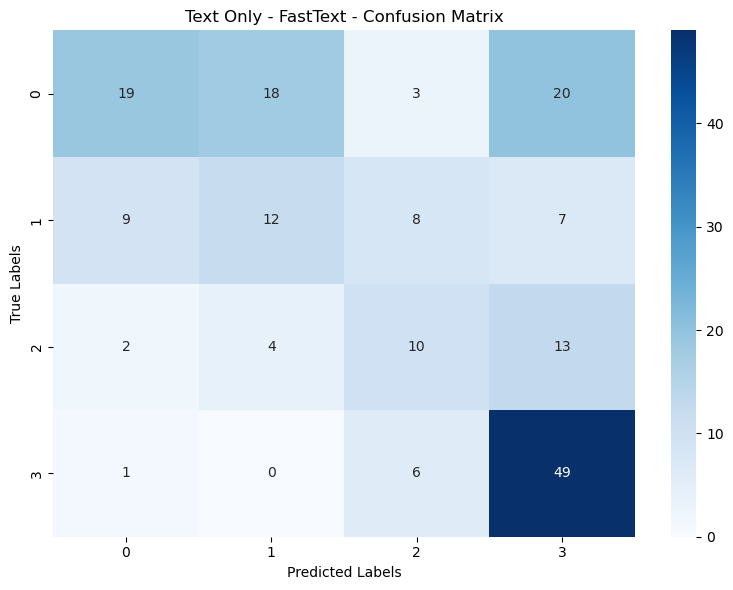


=== Training classification model: Title + Text - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1202
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Title + Text - FastText
Accuracy: 0.525
Precision (weighted): 0.567
Recall (weighted): 0.525
F1 Score (weighted): 0.503

Classification Report:
              precision    recall  f1-score   support

           1      0.769     0.333     0.465        60
           2      0.500     0.500     0.500        36
           3      0.320     0.276     0.296        29
           4      0.521     0.875   

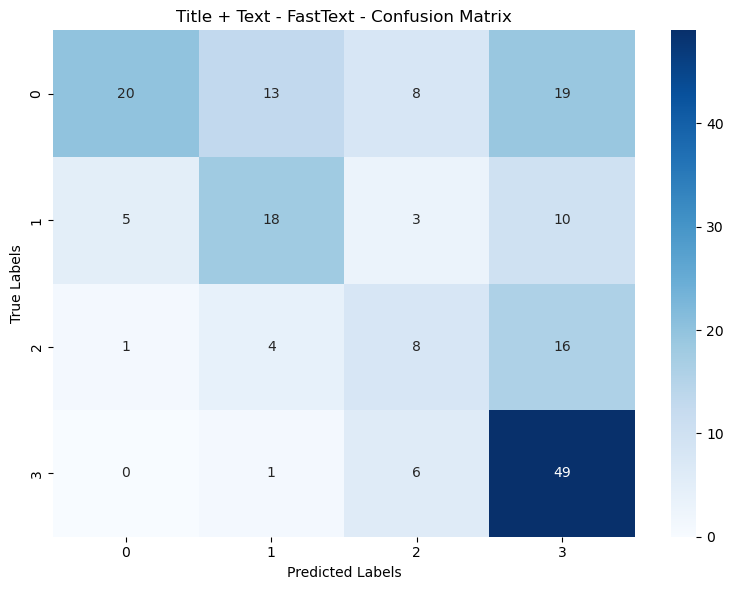


=== Training classification model: All Features - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306629
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1208
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Classification Evaluation for All Features - FastText
Accuracy: 0.735
Precision (weighted): 0.746
Recall (weighted): 0.735
F1 S

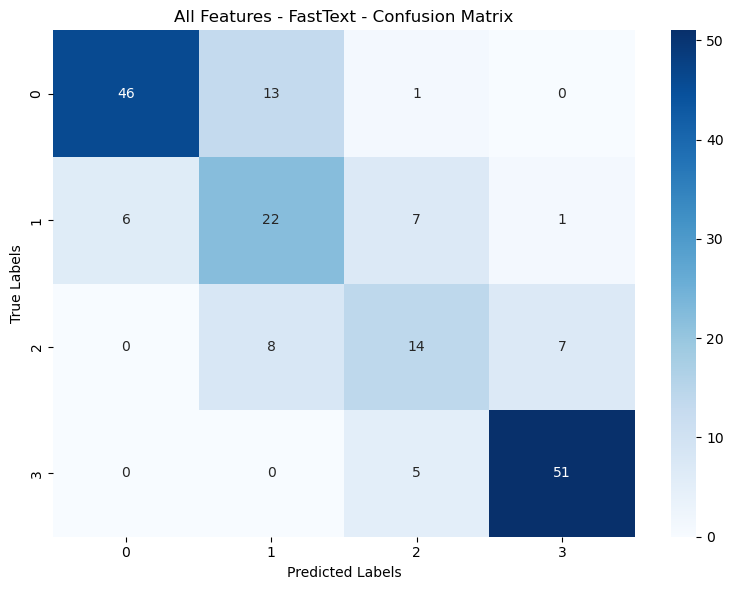

In [13]:
# Load FastText word vectors
print("Loading FastText model...")
if os.path.exists("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv"):
    model2 = KeyedVectors.load("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")  # faster loading
else:
    model2 = KeyedVectors.load_word2vec_format("pretrained_models/fasttext/wiki-news-300d-1M-subword.vec")
    model2.save("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")

results.append(run_classification(train_df, test_df, extract_title_features, model2, "Title Only - FastText"))
results.append(run_classification(train_df, test_df, extract_text_features, model2, "Text Only - FastText"))
results.append(run_classification(train_df, test_df, extract_combined_features, model2, "Title + Text - FastText"))
results.append(run_classification(train_df, test_df, extract_all_features, model2, "All Features - FastText"))


## Classification Word2Vec vs. FastText

In [14]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df.sort_values(by="Model"))


,Model,Accuracy,Precision,Recall,F1 Score
7,All Features - FastText,0.734807,0.745521,0.734807,0.737602
3,All Features - Word2Vec,0.718232,0.736216,0.718232,0.721527
5,Text Only - FastText,0.497238,0.503051,0.497238,0.472946
1,Text Only - Word2Vec,0.552486,0.551569,0.552486,0.541199
6,Title + Text - FastText,0.524862,0.566991,0.524862,0.503239
2,Title + Text - Word2Vec,0.591160,0.589145,0.591160,0.584404
4,Title Only - FastText,0.436464,0.481201,0.436464,0.390225
0,Title Only - Word2Vec,0.513812,0.505169,0.513812,0.489217


## Regression Train/Evaluate

In [15]:
def run_regression(train_df, test_df, feature_func, model, description, save_json_file_name=None):
    print(f"\n=== Running regression on: {description} ===")

    # Extract training features and targets
    X_train = [feature_func(row, model) if model else feature_func(row) for _, row in train_df.iterrows()]
    y_train = train_df["overall"].values

    # Extract test features and targets
    X_test = [feature_func(row, model) if model else feature_func(row) for _, row in test_df.iterrows()]
    y_test = test_df["overall"].values

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    reg = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbm', LGBMRegressor(n_estimators=100, random_state=42))
    ])
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    results = common_evaluation.evaluate_regression(  # assuming this exists in your module
        y_true=y_test,
        y_pred=y_pred,
        description=description,
        save_json_file_name=save_json_file_name
    )

    return results

## Regression with Word2Vec


=== Running regression on: Title Only - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Title Only - Word2Vec
Mean Squared Error (MSE): 1.014
Mean Absolute Error (MAE): 0.770
R2 Score: 0.318
Pearson Correlation (r): 0.623


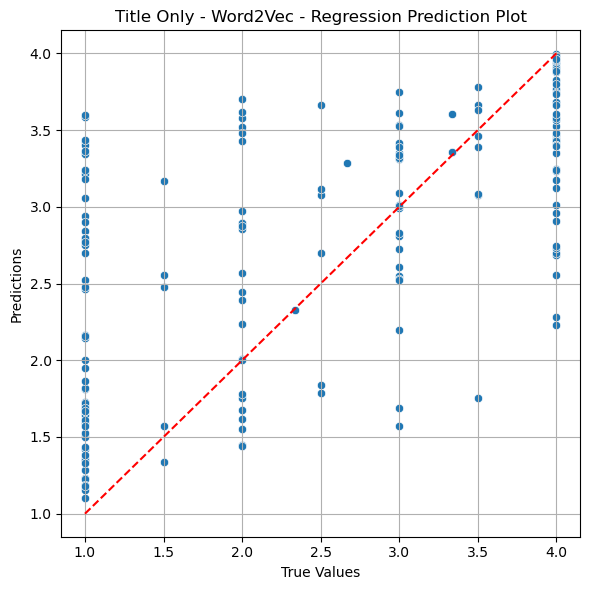


=== Running regression on: Text Only - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Text Only - Word2Vec
Mean Squared Error (MSE): 0.904
Mean Absolute Error (MAE): 0.719
R2 Score: 0.392
Pearson Correlation (r): 0.653


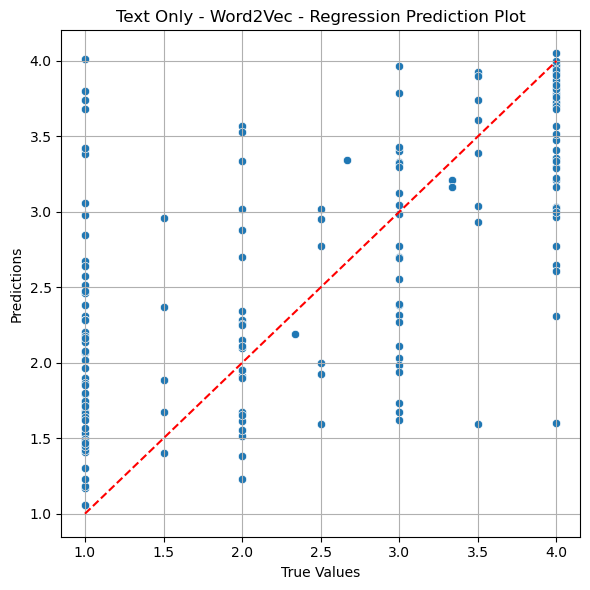


=== Running regression on: Title + Text - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1202
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Title + Text - Word2Vec
Mean Squared Error (MSE): 0.775
Mean Absolute Error (MAE): 0.652
R2 Score: 0.479
Pearson Correlation (r): 0.710


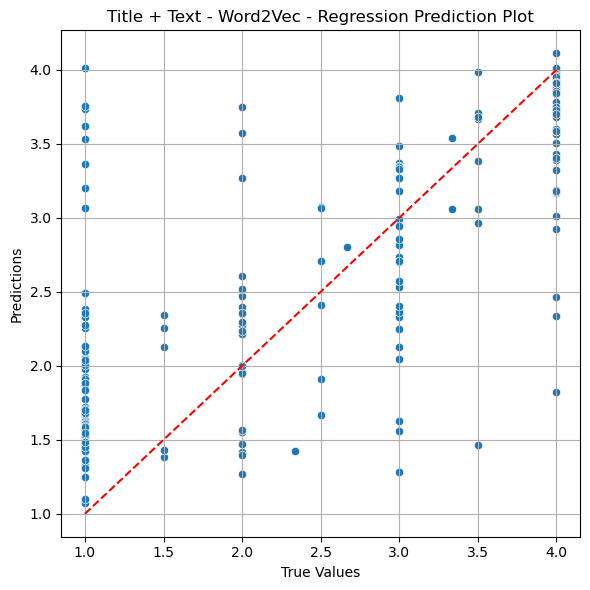


=== Running regression on: All Features - Word2Vec ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306629
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1208
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for All Features - Word2Vec
Mean Squared Error (MSE): 0.238
Mean Absolute Error (MAE): 0.325
R2 Score: 0.840
Pearson Correlation (r): 0.920


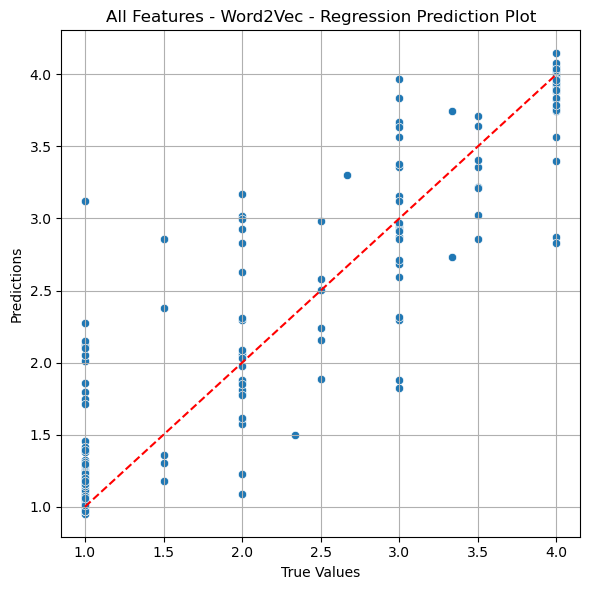

In [16]:
regression_results = []

regression_results.append(run_regression(train_df, test_df, extract_title_features, model, "Title Only - Word2Vec"))
regression_results.append(run_regression(train_df, test_df, extract_text_features, model, "Text Only - Word2Vec"))
regression_results.append(run_regression(train_df, test_df, extract_combined_features, model, "Title + Text - Word2Vec"))
regression_results.append(run_regression(train_df, test_df, extract_all_features, model, "All Features - Word2Vec"))

## Regression with FastText


=== Running regression on: Title Only - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Title Only - FastText
Mean Squared Error (MSE): 1.225
Mean Absolute Error (MAE): 0.886
R2 Score: 0.176
Pearson Correlation (r): 0.573


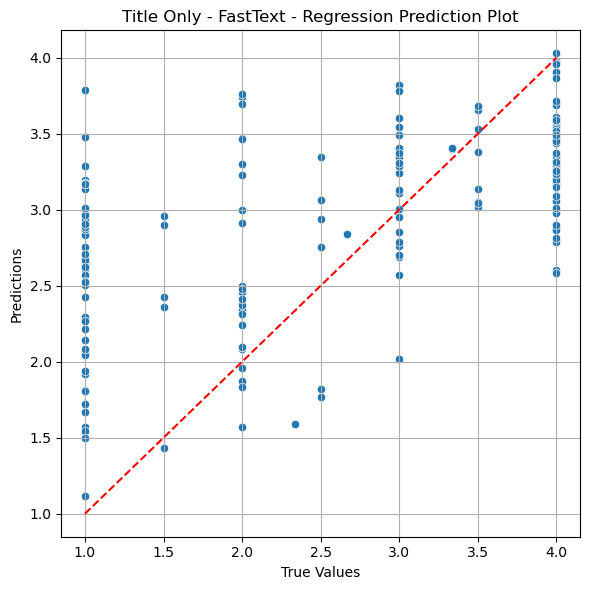


=== Running regression on: Text Only - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Text Only - FastText
Mean Squared Error (MSE): 1.024
Mean Absolute Error (MAE): 0.790
R2 Score: 0.311
Pearson Correlation (r): 0.623


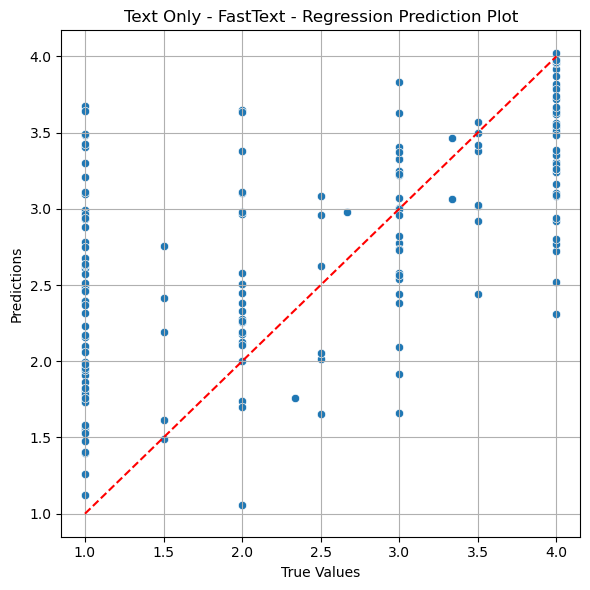


=== Running regression on: Title + Text - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1202
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Title + Text - FastText
Mean Squared Error (MSE): 1.025
Mean Absolute Error (MAE): 0.790
R2 Score: 0.310
Pearson Correlation (r): 0.637


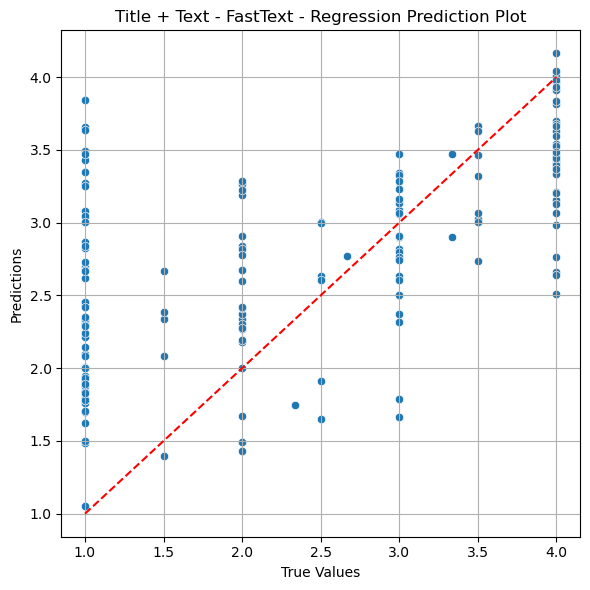


=== Running regression on: All Features - FastText ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306629
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1208
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for All Features - FastText
Mean Squared Error (MSE): 0.209
Mean Absolute Error (MAE): 0.312
R2 Score: 0.859
Pearson Correlation (r): 0.930


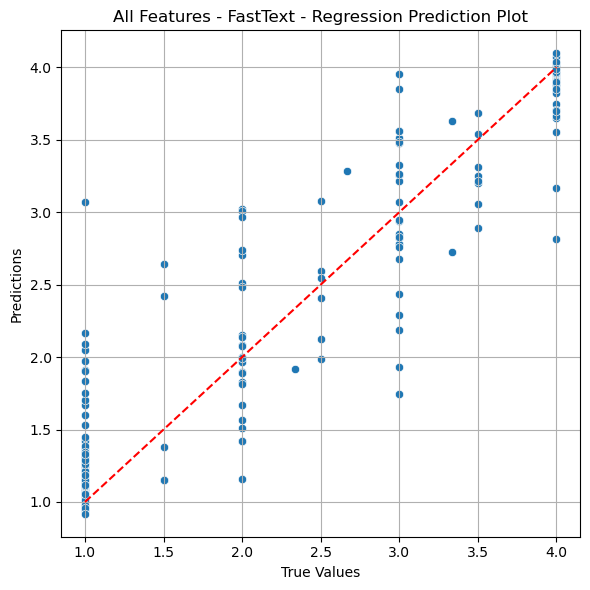

In [17]:
regression_results.append(run_regression(train_df, test_df, extract_title_features, model2, "Title Only - FastText"))
regression_results.append(run_regression(train_df, test_df, extract_text_features, model2, "Text Only - FastText"))
regression_results.append(run_regression(train_df, test_df, extract_combined_features, model2, "Title + Text - FastText"))
regression_results.append(run_regression(train_df, test_df, extract_all_features, model2, "All Features - FastText"))

## Regression Word2Vec vs. FastText

In [18]:
# Convert to DataFrame
regression_results_df = pd.DataFrame(regression_results)
display(regression_results_df.sort_values(by="Model"))


,Model,MSE,MAE,R2,Pearson Correlation
7,All Features - FastText,0.208921,0.311577,0.859479,0.929617
3,All Features - Word2Vec,0.237908,0.325161,0.839982,0.919762
5,Text Only - FastText,1.024405,0.789533,0.310983,0.623336
1,Text Only - Word2Vec,0.904214,0.719072,0.391824,0.653481
6,Title + Text - FastText,1.025304,0.790203,0.310378,0.637327
2,Title + Text - Word2Vec,0.775238,0.651878,0.478573,0.709739
4,Title Only - FastText,1.225388,0.885672,0.175801,0.573180
0,Title Only - Word2Vec,1.014464,0.769682,0.317669,0.622893
